# Project Notebook


## Before you start:
* **Make your own copy** of this notebook
  * Select 'File' --> 'Save a copy in Drive...'
  * Add your name in front of the title of the notebook by clicking on the file name above.  

---
---
# Predict Severity Of Car Accidents in UK
---
---

***
## Authorship and Resources Used
* Weifan Zhou
* Professor Brad Sheese (I referenced the helper function)
* I asked ChatGPT for how to sort the most important 15 features and use bar plot for visualizing coefficients.
* Reference:
  * This [link](https://stackoverflow.com/questions/43427564/display-all-information-with-data-info-in-pandas) helped me solve when non-null counts does not show up.
  * This [link](https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python) from stack overflow told me how to apply smote and k-fold at the same time.
  * This [link](https://stackoverflow.com/questions/11346283/renaming-column-names-in-pandas) taught be to rename a column.

***
## Data Description and Source
* The dataset contains two parts: accident data which indicates more of external factors such as environment and road conditions, and vehicle data which recorded drivers' information. The dataset is predicting 3 types of severity of car accidents: slight, serious, or fatal (deadly).
* There are several types of features: location, weather, road information, and drivers or cars' information.
* The outcome is hugely imbalance. After data cleaning, there's 88% slight, 11% Serious, and 0.88% fatal.
* Data Source: [UK Road Traffic Collision Dataset, Kaggle](https://www.kaggle.com/datasets/salmankhaliq22/road-traffic-collision-dataset/data?select=vehicle_data.csv). It contains the description of datasets in the csv area.
* The Kaggle data was from the British Government from this [link](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data).

***
## Research Question
* My research question is to predict car accident severity levels based on environmental factors and drivers.

* A potential use of this dataset is to manage medical resources and police stations for emergency response, especially in areas where accidents are likely to occur. This dataset's topic is also useful for identifying places where renovating or reconstructing road systems is necessary, formulating traffic policies for car users, and preparing for unexpected weather conditions that make driving more dangerous.

* I am strongly interested in urban topics, especially those related to spatial analysis (though as of 2023, I do not have much experience in that). This dataset represents my first attempt at urban transportation analysis, and so far, it's the largest dataset I've used. Even if my current knowledge is not sufficient for obtaining accurate results from the dataset, I hope it serves as a good introduction to my future research topics.

***
## Import Libraries and Set Preferences for Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

***
## Read and Verify Data


In [ ]:
#Accident Data
url = "https://media.githubusercontent.com/media/weifanz/CS-377-Applied-Data-Analysis-Course-Projects/main/Multiclass%20Classification%20--%20Car%20Accidents/accident_data.csv"
df_accident = pd.read_csv(url)
df_accident.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,None,04/01/2005,Tuesday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,None,05/01/2005,Wednesday,1.0,...,Metropolitan Police,Dry,Dual carriageway,None,30,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,None,06/01/2005,Thursday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,None,07/01/2005,Friday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,NaN,0.0,NaN,0.0,Slight,None,10/01/2005,Monday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30,21:13,Urban,Fine no high winds,2005,No


In [ ]:
#Vehicle Data
url = 'https://media.githubusercontent.com/media/weifanz/CS-377-Applied-Data-Analysis-Course-Projects/main/Multiclass%20Classification%20--%20Car%20Accidents/vehicle_data.csv'
df_vehicle = pd.read_csv(url, encoding = 'latin1')
df_vehicle.head()

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year
0,200401BS00001,26 - 35,3.0,Urban area,4.0,1588.0,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,Data missing or out of range,Front,2004
1,200401BS00002,26 - 35,NaN,Urban area,3.0,NaN,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,Data missing or out of range,Front,2004
2,200401BS00003,26 - 35,4.0,Data missing or out of range,NaN,998.0,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,Data missing or out of range,Front,2004
3,200401BS00003,66 - 75,NaN,Data missing or out of range,NaN,NaN,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,Data missing or out of range,Front,2004
4,200401BS00004,26 - 35,1.0,Urban area,4.0,124.0,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,Data missing or out of range,Front,2004


In [ ]:
df = pd.merge(df_accident, df_vehicle, on='Accident_Index')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528335 entries, 0 to 528334
Data columns (total 57 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               528335 non-null  object 
 1   1st_Road_Class                               398256 non-null  object 
 2   1st_Road_Number                              528334 non-null  float64
 3   2nd_Road_Class                               323866 non-null  object 
 4   2nd_Road_Number                              523845 non-null  float64
 5   Accident_Severity                            528335 non-null  object 
 6   Carriageway_Hazards                          528320 non-null  object 
 7   Date                                         528335 non-null  object 
 8   Day_of_Week                                  528335 non-null  object 
 9   Did_Police_Officer_Attend_Scene_of_Accident  528269 non-nul

### Clean car accidents dataset

In [ ]:
df = df.replace("Data missing or out of range", np.nan)

for col in df:
  if df[col].nunique() < 11:
    print(f"Feature: {col}\n{df[col].value_counts()}\n")
    print(f"{col} Missing: {df[col].isnull().sum()}\n---------------------------\n")

drop_lst = []

for col in df.select_dtypes(exclude = [int, float]):
  if df[col].nunique() >= 11:
    print(f"Feature: {col}\nMissing: {df[col].nunique()}\n")
    drop_lst.append(col)

print("Drop List: " + str(drop_lst))

Feature: 1st_Road_Class
A           258620
B            66075
C            44830
Motorway     27032
A(M)          1699
Name: 1st_Road_Class, dtype: int64

1st_Road_Class Missing: 130079
---------------------------

Feature: 2nd_Road_Class
Unclassified    212095
A                58155
C                26742
B                22534
Motorway          3945
A(M)               395
Name: 2nd_Road_Class, dtype: int64

2nd_Road_Class Missing: 204469
---------------------------

Feature: Accident_Severity
Slight     457171
Serious     63913
Fatal        7251
Name: Accident_Severity, dtype: int64

Accident_Severity Missing: 0
---------------------------

Feature: Carriageway_Hazards
None                                               519578
Other object on road                                 3823
Any animal in carriageway (except ridden horse)      2131
Previous accident                                    1163
Pedestrian in carriageway - not injured               957
Vehicle load on road          

* I found that missing values for "Light_Conditions” column indicates "Daylight" according to the "Time" column. So, I will replace missing values in "Light_Conditions" with "Daylight".


In [ ]:
#A(M) and A indicates the same road level
df = df.replace('A(M)', 'A')

#Missing values in light_conditions indicate daylight.
df['Light_Conditions'] = df['Light_Conditions'].replace(np.nan, "Daylight")
df['Light_Conditions'] = df['Light_Conditions'].replace('Darkness - lights unlit', 'Darkness - no lighting')

#Make "unallocated" data into missing values
df['Urban_or_Rural_Area'] = df['Urban_or_Rural_Area'].replace('Unallocated', np.nan)

#"Sigl" and "signal" indicates the same thing
df['Special_Conditions_at_Site'] = df['Special_Conditions_at_Site'].replace({'Auto traffic sigl - out': 'Auto traffic signal - out',
                                                                             'Auto sigl part defective': 'Auto signal part defective'})
df['Junction_Control'] = df['Junction_Control'].replace('Auto traffic sigl', 'Auto traffic signal')

#Replace "No (2)" or "No, the accident is self-reported(3)" with "0"
df['Did_Police_Officer_Attend_Scene_of_Accident'] = df['Did_Police_Officer_Attend_Scene_of_Accident'].replace({2: 0, 3: 0})
df = df.rename(columns={'Did_Police_Officer_Attend_Scene_of_Accident': 'Police_Officer_Came'})

#Make urban "1" and rural "0"
df['Urban_or_Rural_Area'] = df['Urban_or_Rural_Area'].replace({'Urban': 1, 'Rural': 0})
df = df.rename(columns={'Urban_or_Rural_Area': 'Urban_Area'})

#Make male "1" and female "0". And make "not known" as missing value
df['Sex_of_Driver'] = df['Sex_of_Driver'].replace({'Male': 1, 'Female': 0, 'Not known': np.nan})
df = df.rename(columns={'Sex_of_Driver': 'Sex_of_Driver_Male'})

#Merge some categories for 'Propulsion_Code' (Oli Type)
df['Propulsion_Code'] = df['Propulsion_Code'].replace({'Petrol/Gas (LPG)': 'Gas/Bi-fuel (with Petrol)',
                                                       'Gas': 'Gas/Bi-fuel (with Petrol)',
                                                       'Hybrid electric': 'Hybrid electric/ Electric',
                                                       'Electric': 'Hybrid electric/ Electric',
                                                       'New fuel technology': np.nan,
                                                       'Gas Diesel': np.nan})
df = df.rename(columns={'Propulsion_Code': 'Oil Type'})

In [ ]:
#Drop Features and missing values
drop_lst.append('1st_Road_Number')
drop_lst.append('2nd_Road_Number')
drop_lst.append('Year_x')
drop_lst.append('Year_y')
drop_lst.append('Day_of_Week')

df = df.drop(columns = drop_lst)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160911 entries, 7 to 528307
Data columns (total 38 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   1st_Road_Class                           160911 non-null  object 
 1   2nd_Road_Class                           160911 non-null  object 
 2   Accident_Severity                        160911 non-null  object 
 3   Carriageway_Hazards                      160911 non-null  object 
 4   Police_Officer_Came                      160911 non-null  float64
 5   Junction_Control                         160911 non-null  object 
 6   Junction_Detail                          160911 non-null  object 
 7   Latitude                                 160911 non-null  float64
 8   Light_Conditions                         160911 non-null  object 
 9   Location_Easting_OSGR                    160911 non-null  float64
 10  Location_Northing_OSGR          

In [ ]:
df = df.replace({'Yes': 1, 'No': 0})

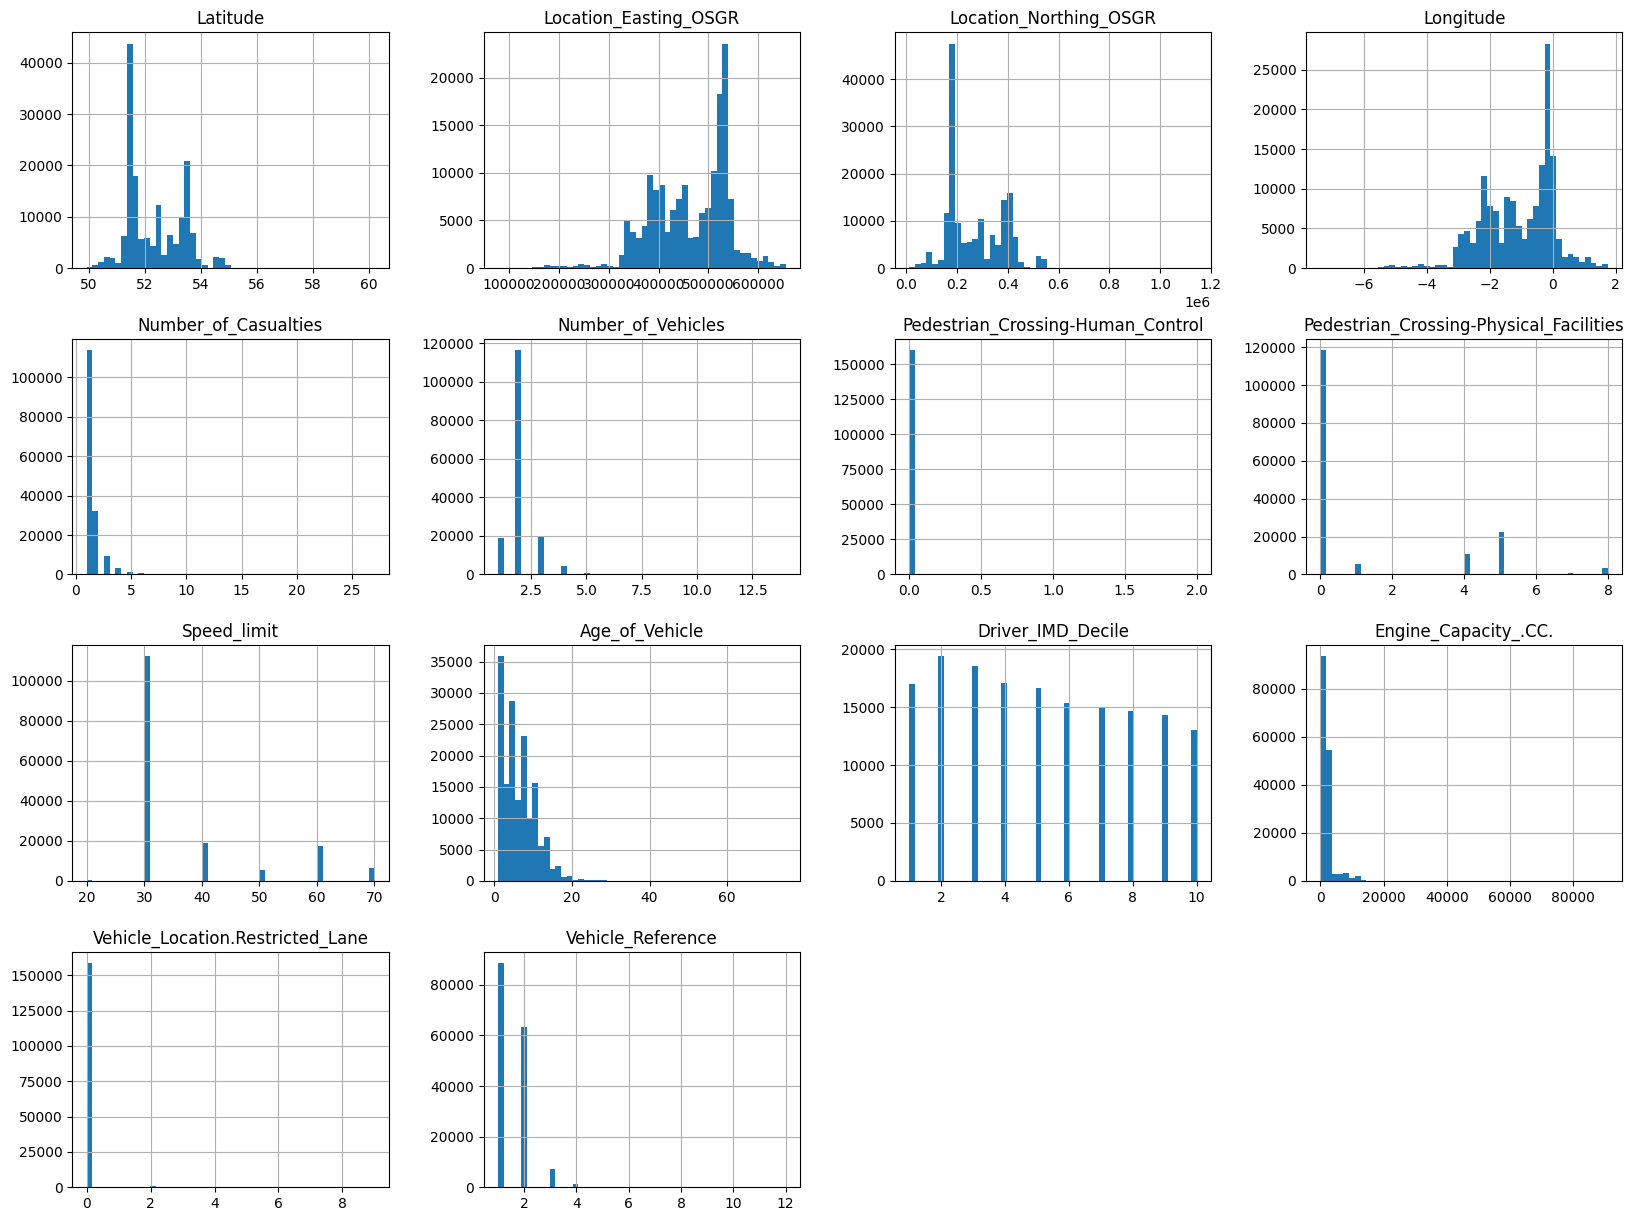

In [ ]:
for col in df:
  if df[col].nunique() == 2:
    df[col] = df[col].astype('category')

df.hist(bins = 50, figsize = (20,15))
plt.show()

<ipython-input-11-f61105d15bee>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data = df.corr() ,annot = True, cmap = "YlGnBu")


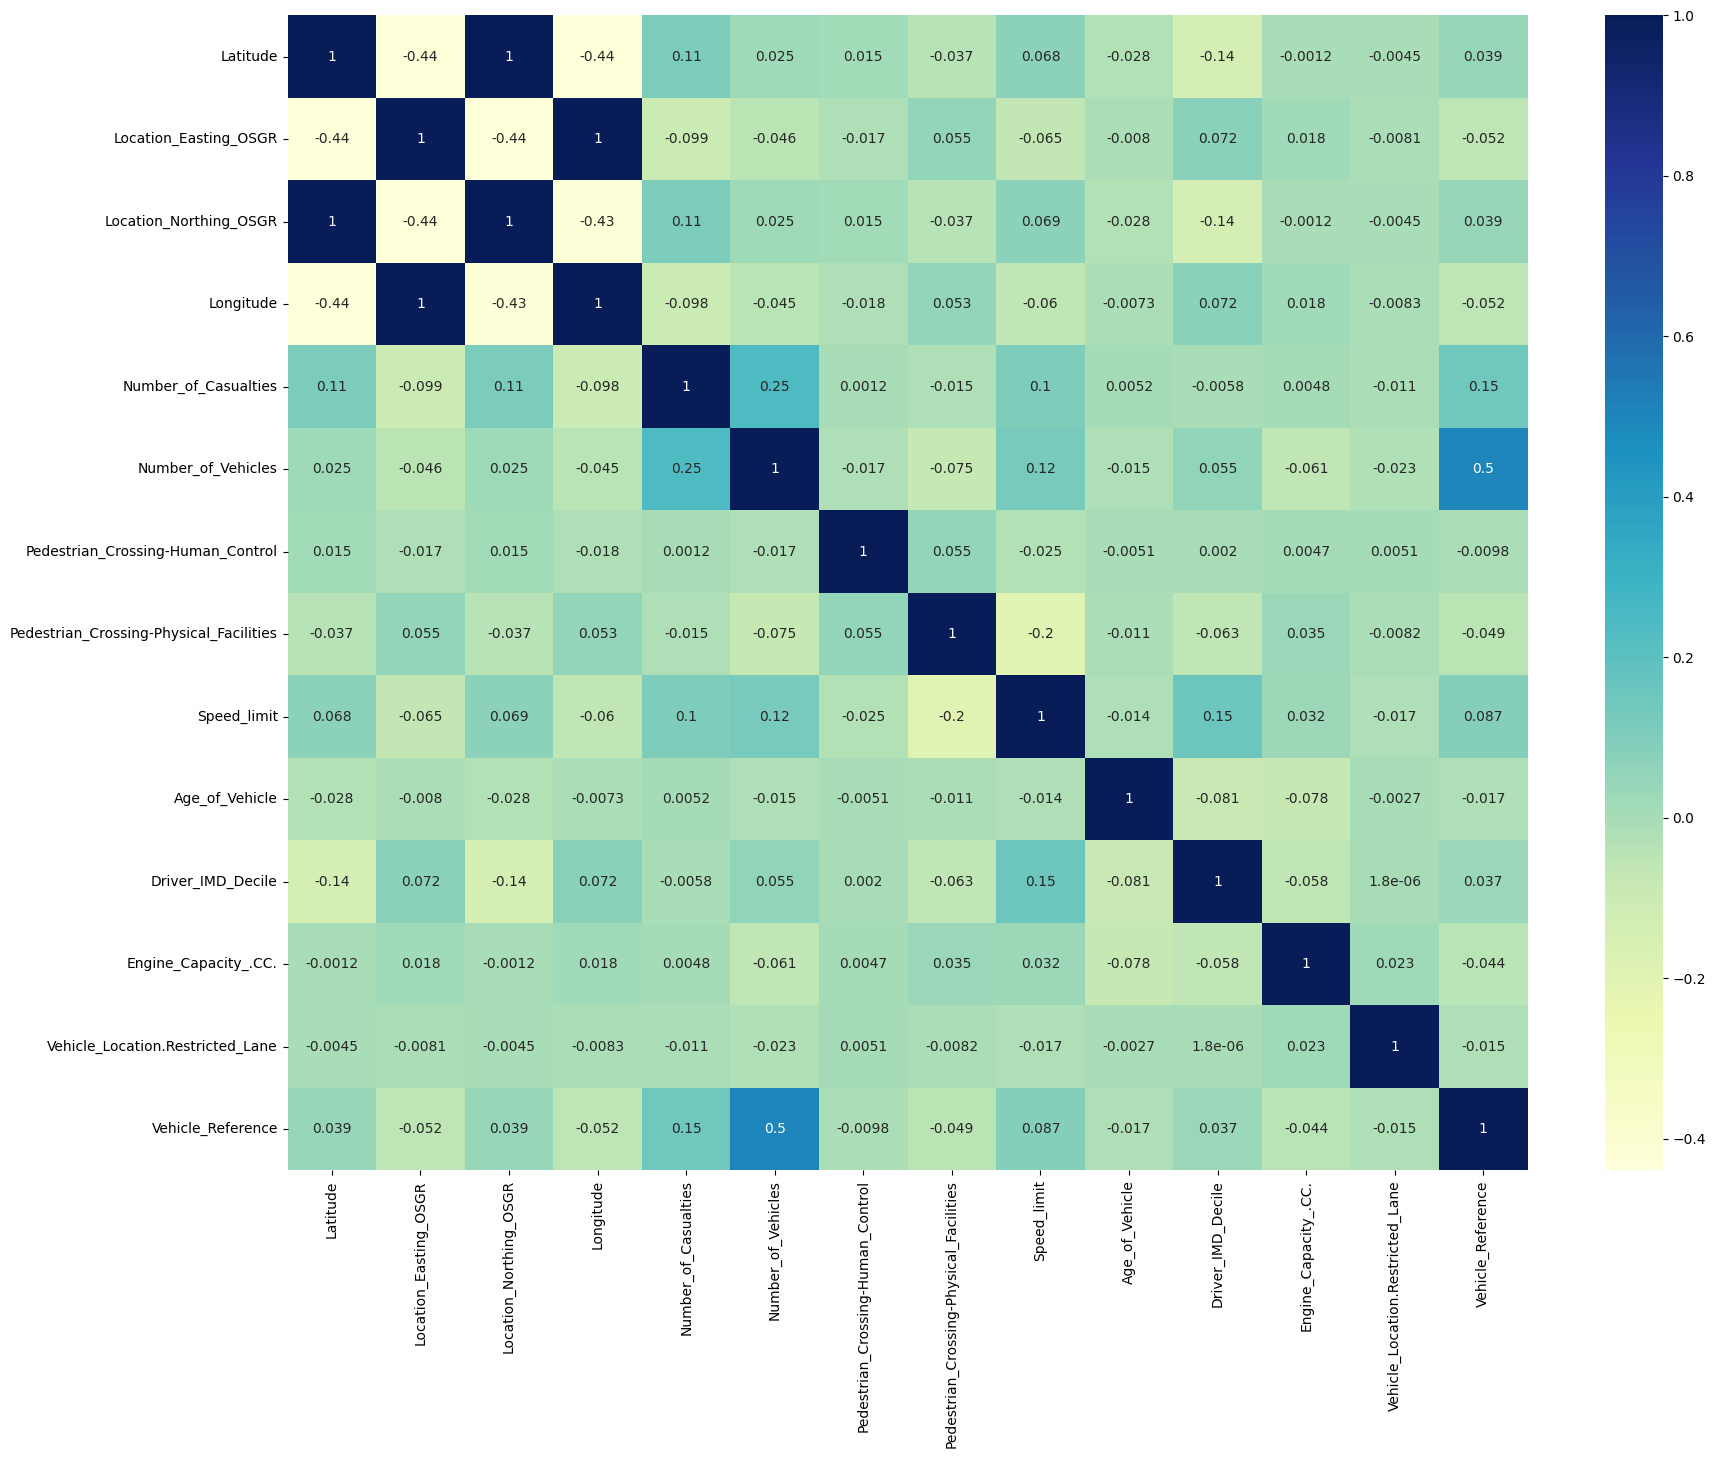

In [ ]:
plt.figure(figsize = (20, 15))
sns.heatmap(data = df.corr() ,annot = True, cmap = "YlGnBu")
plt.show()

Location data has high multicolinearity, so I will drop some. (Note: They all seems representing Scotland).

In [ ]:
df = df.drop(columns = ['Location_Easting_OSGR', 'Vehicle_Reference'])
df['Accident_Severity'] = df['Accident_Severity'].astype('category')

In [ ]:
for col in df.select_dtypes('object'):
  if col != 'Accident_Severity':
    df = pd.get_dummies(df, columns = [col])

In [ ]:
y = df['Accident_Severity']
X = df.loc[:, df.columns != 'Accident_Severity']

In [ ]:
y.value_counts()

Slight     141602
Serious     17893
Fatal        1416
Name: Accident_Severity, dtype: int64

In [ ]:
print(f"Slight: {(141602/y.count()*100).round(2)}%")
print(f"Serious: {(17893/y.count()*100).round(2)}%")
print(f"Fatal: {(1416/y.count()*100).round(2)}%")

Slight: 88.0%
Serious: 11.12%
Fatal: 0.88%


This is an extremely imbalanced dataset, but that percentage fits real life because there isn't that much serious accidents compare to slight ones.

***
## Analyses and Visualizations


There are way more people in England than Scottland, longitude & latitude data spread apart.

### Base Model

Helper Function (borrowed from Professor Sheese's homework assignment)

In [ ]:
def run_classification(df):
    y_encoded = y

    # Convert y_encoded to a numpy array if it's a pandas Series
    if isinstance(y_encoded, pd.Series):
        y_encoded = y_encoded.to_numpy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize K-Fold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize the model
    clf = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=3000, n_jobs = -1)

    # Class labels
    class_labels = y.unique()

    # Confusion Matrix for 'Slight' misclassifications and classification report data
    slight_misclassifications = np.zeros(len(class_labels), dtype=int)
    all_y_test = []
    all_y_pred = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X_scaled, y_encoded):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # I used random under sampling. Otherwise, this program "forever" runs
        method = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = method.fit_resample(X_train, y_train)

        # Fit the model
        clf.fit(X_train, y_train)

        # Make predictions
        y_pred = clf.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        # Confusion Matrix for the fold
        conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

    # Print the classification report
    print(f"\nClassification Report. Model Type: Logistic Regression \n")
    print(classification_report(all_y_test, all_y_pred, labels=class_labels))

    # Binarize the labels for roc_curve
    y_bin = label_binarize(all_y_test, classes=class_labels)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], clf.predict_proba(X_scaled)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_labels[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multiclass Base Model. Model Type: Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix of Base Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    # Get the most important features:
    coefficients = clf.coef_
    feature_importances = np.abs(coefficients)

    # Sort feature importances in descending order and get the indices
    indices = feature_importances.argsort()[::-1]

    # Plotting the top 15 features
    plt.figure(figsize=(12, 8))
    plt.barh(range(15), coefficients[0][indices[0]][:15], align="center")
    plt.yticks(range(15), X.columns[indices[0][:15]])
    plt.xlabel("Beta")
    plt.ylabel("Feature")
    plt.title("Top 15 Feature Importances in Logistic Regression".format(15))
    plt.show()

#### Logistic Regression


Classification Report. Model Type: Logistic Regression 

              precision    recall  f1-score   support

      Slight       0.99      0.01      0.02    141602
     Serious       0.11      1.00      0.20     17893
       Fatal       0.10      0.01      0.02      1416

    accuracy                           0.12    160911
   macro avg       0.40      0.34      0.08    160911
weighted avg       0.89      0.12      0.04    160911



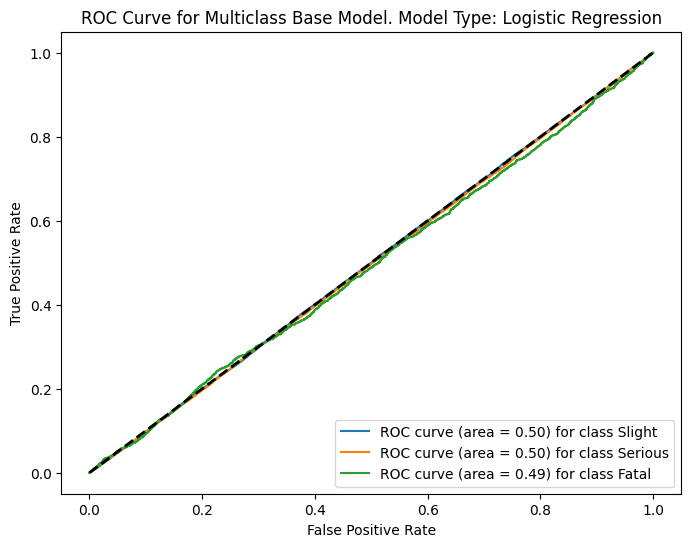

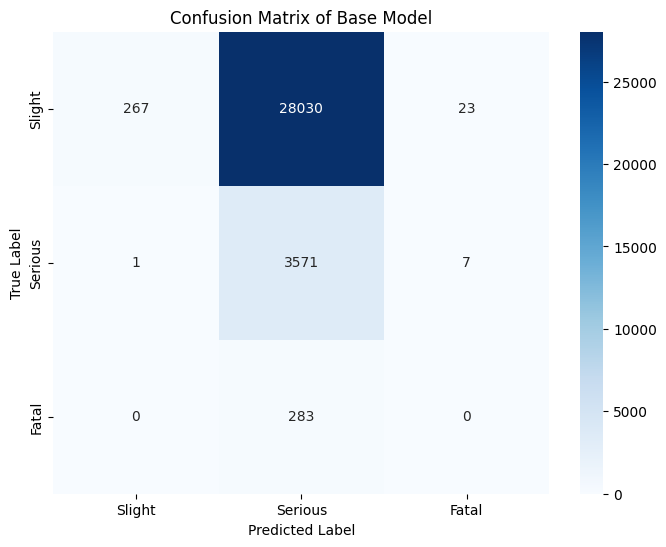

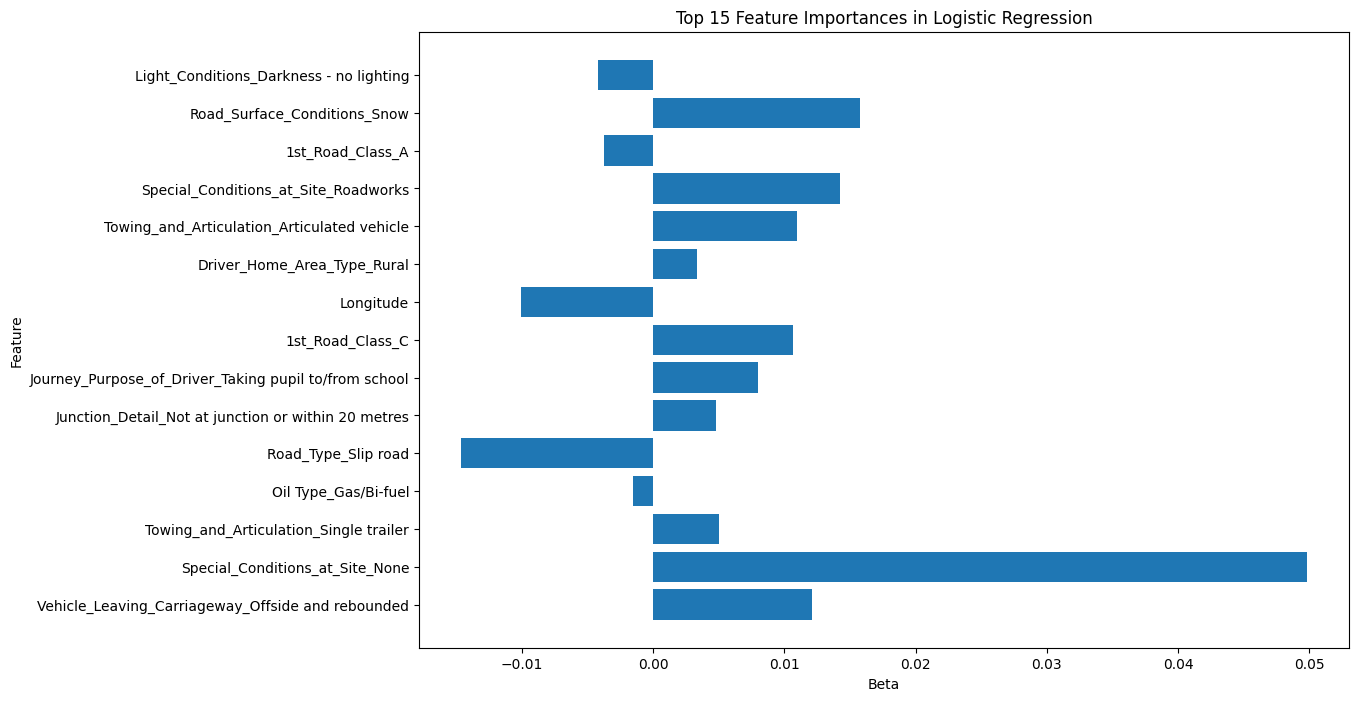

In [ ]:
run_classification(df)

In the barh plot we can see which features are 15 important features (not ranked in the plot). However, it is hard to interpret positive or negative coefficients because there are 3 outcomes, and we don't know which feature makes which outcome more likely to occur. Logistic regression does not use 1, 2, 3 as outcomes.

### Regularization Models

It seems the model still strongly favors "serious" class. That's probably due to the random undersampler method. Here I tried SMOTE but the program runs forever... So, I kept using random undersampler.

A helper function revised from the previous base model function.

In [ ]:
def run_regularized(df, penalty = 'l2', C = 0.1):
    y_encoded = y

    # Convert y_encoded to a numpy array if it's a pandas Series
    if isinstance(y_encoded, pd.Series):
        y_encoded = y_encoded.to_numpy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize K-Fold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize the model
    clf = LogisticRegression(multi_class='multinomial', penalty= penalty, C = C, solver='saga', max_iter=3000, n_jobs = -1)

    # Class labels
    class_labels = y.unique()

    # Confusion Matrix for 'Slight' misclassifications and classification report data
    slight_misclassifications = np.zeros(len(class_labels), dtype=int)
    all_y_test = []
    all_y_pred = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X_scaled, y_encoded):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        method = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = method.fit_resample(X_train, y_train)

        # Fit the model
        clf.fit(X_train, y_train)

        # Make predictions
        y_pred = clf.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        # Confusion Matrix for the fold
        conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

    # Print the classification report
    print(f"\nClassification Report for LogReg. Penalty Type: {penalty} \n")
    print(classification_report(all_y_test, all_y_pred, labels=class_labels))

    # Binarize the labels for roc_curve
    y_bin = label_binarize(all_y_test, classes=class_labels)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], clf.predict_proba(X_scaled)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_labels[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multiclass Regularized Model. Penalty Type: {penalty}')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix of {penalty} Penalty')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Get the most important features:
    coefficients = clf.coef_
    feature_importances = np.abs(coefficients)

    # Sort feature importances in descending order and get the indices
    indices = feature_importances.argsort()[::-1]

    # Plotting the top 15 features
    plt.figure(figsize=(12, 8))
    plt.barh(range(15), coefficients[0][indices[0]][:15], align="center")
    plt.yticks(range(15), X.columns[indices[0][:15]])
    plt.xlabel("Beta")
    plt.ylabel("Feature")

    if penalty == 'l2':
        plt.title("Top 15 Feature Importances in Logistic Regression (Ridge)".format(15))
    else:
        plt.title("Top 15 Feature Importances in Logistic Regression (Lasso)".format(15))
    plt.show()

#### Ridge Regression


Classification Report for LogReg. Penalty Type: l2 

              precision    recall  f1-score   support

      Slight       0.99      0.01      0.03    141602
     Serious       0.11      1.00      0.20     17893
       Fatal       0.09      0.01      0.02      1416

    accuracy                           0.12    160911
   macro avg       0.40      0.34      0.08    160911
weighted avg       0.89      0.12      0.05    160911



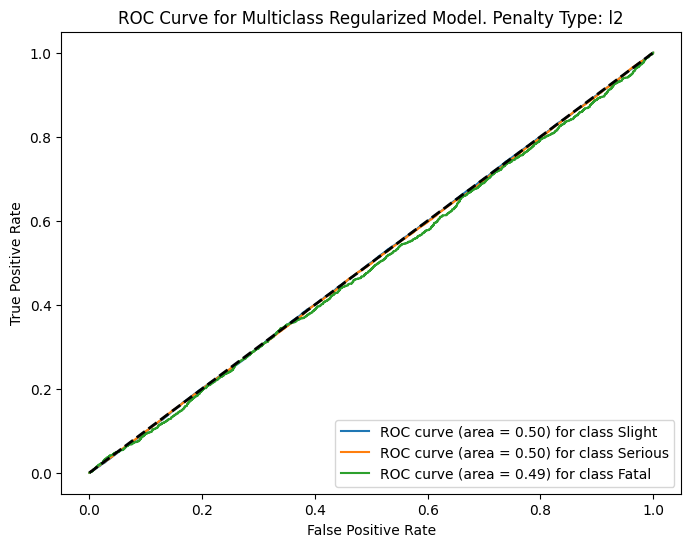

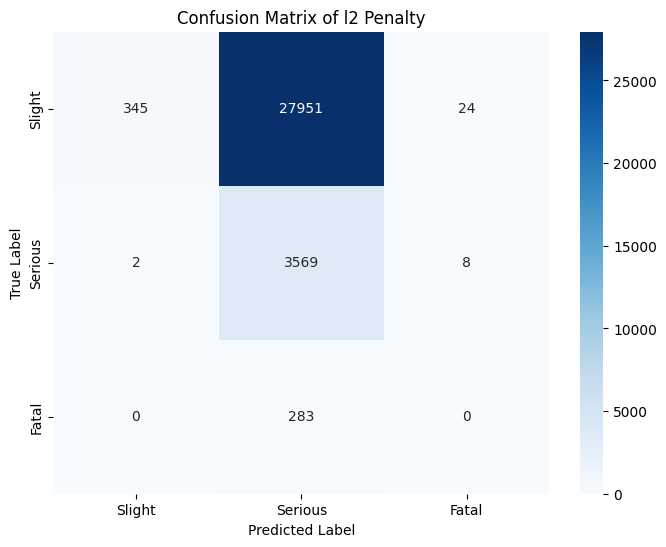

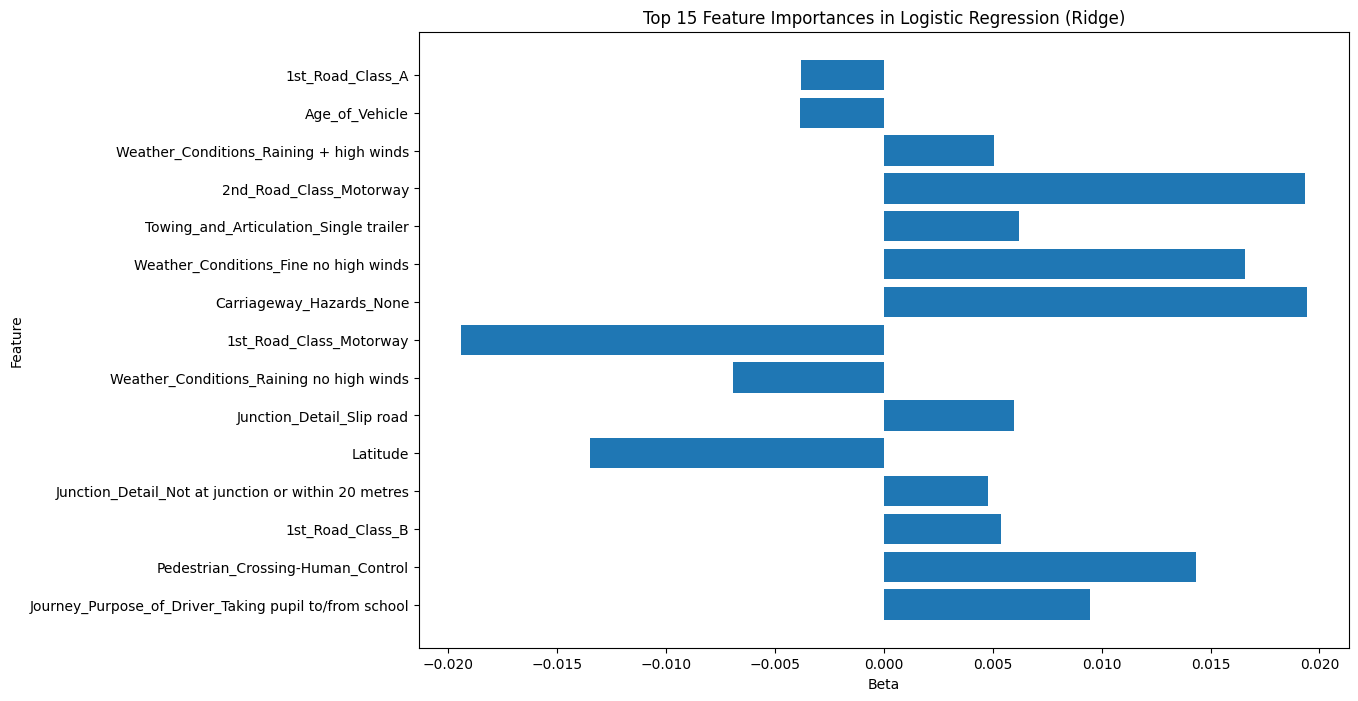

In [ ]:
run_regularized(df, penalty = 'l2', C = 1)

#### Lasso Regression


Classification Report for LogReg. Penalty Type: l1 

              precision    recall  f1-score   support

      Slight       0.99      0.02      0.03    141602
     Serious       0.11      1.00      0.20     17893
       Fatal       0.10      0.01      0.02      1416

    accuracy                           0.13    160911
   macro avg       0.40      0.34      0.08    160911
weighted avg       0.89      0.13      0.05    160911



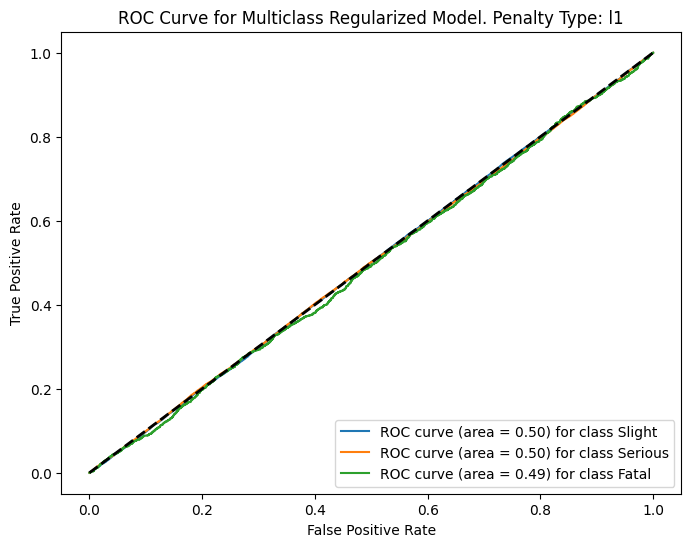

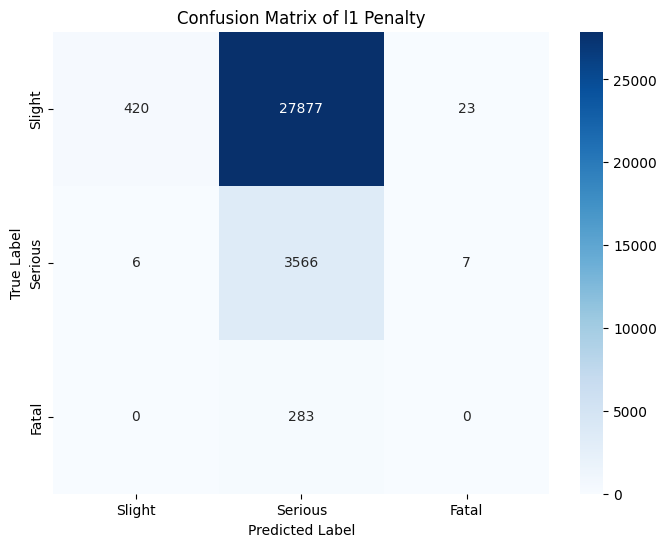

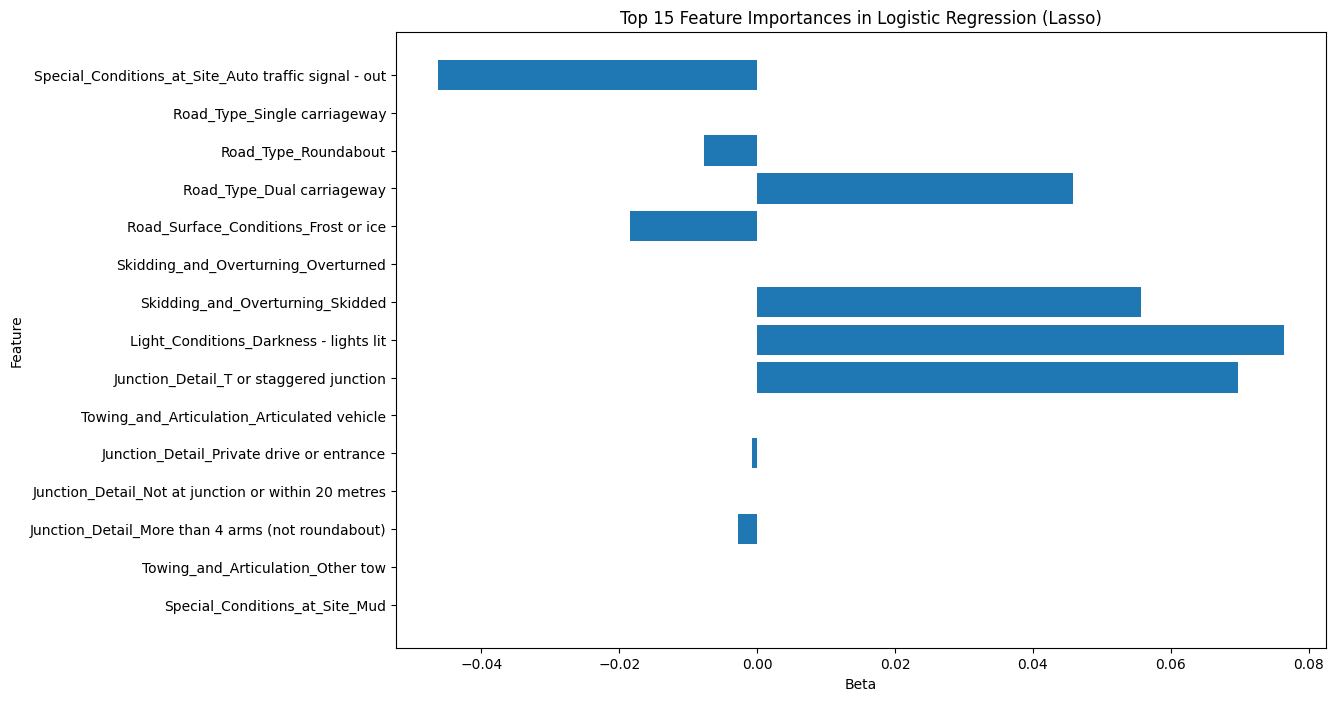

In [ ]:
run_regularized(df, penalty = 'l1', C = 1)

Those blue bars visible in the barh plot are features remaining. In the plot they are not sorted, but those features are chosen to be the most important features. Some features, like "Special_Conditions_at_Site_Mud", are too small and negligible.

Summarize: using C=1 gives worse predictions.

### Extra Models

Since tree methods run faster than logistic regression, I can use SMOTE instead of random undersampler.

In [ ]:
def run_tree(df, model_type = 'xgb', max_depth = 7):
    # Convert string labels to integers for XGB
    if model_type == 'xgb':
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        y_encoded = y

    # Convert y_encoded to a numpy array if it's a pandas Series
    if isinstance(y_encoded, pd.Series):
        y_encoded = y_encoded.to_numpy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize K-Fold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize the model
    if model_type == 'xgb':
      clf = XGBClassifier(use_label_encoder=False, max_depth=max_depth, eval_metric='mlogloss', n_jobs = -1)

    elif model_type == 'rf':
      clf = RandomForestClassifier(max_depth=max_depth, random_state=42, n_jobs = -1)

    elif model_type == 'decision_tree':
      clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    else:
        raise ValueError("Invalid model type")

    # Class labels
    class_labels = y.unique()

    # Confusion Matrix for 'Slight' misclassifications and classification report data
    slight_misclassifications = np.zeros(len(class_labels), dtype=int)
    all_y_test = []
    all_y_pred = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X_scaled, y_encoded):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        method = SMOTE()
        X_train, y_train = method.fit_resample(X_train, y_train)

        # Fit the model
        clf.fit(X_train, y_train)

        # Make predictions
        y_pred = clf.predict(X_test)

        # Store predictions and true values for classification report
        if model_type == 'xgb':
            # Convert predictions and y_test back to original class labels
            y_pred = label_encoder.inverse_transform(y_pred)
            y_test = label_encoder.inverse_transform(y_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        # Confusion Matrix for the fold
        conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

    # Print the classification report
    print(f"\nClassification Report. Model Type: {model_type} \n")
    print(classification_report(all_y_test, all_y_pred, labels=class_labels))

    # Binarize the labels for roc_curve
    y_bin = label_binarize(all_y_test, classes=class_labels)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], clf.predict_proba(X_scaled)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_labels[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Tree Model. Model Type: {model_type}')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix of {model_type} Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#### Decision Tree


Classification Report. Model Type: decision_tree 

              precision    recall  f1-score   support

      Slight       0.90      0.81      0.85    141602
     Serious       0.16      0.11      0.13     17893
       Fatal       0.03      0.44      0.05      1416

    accuracy                           0.73    160911
   macro avg       0.36      0.45      0.35    160911
weighted avg       0.81      0.73      0.77    160911



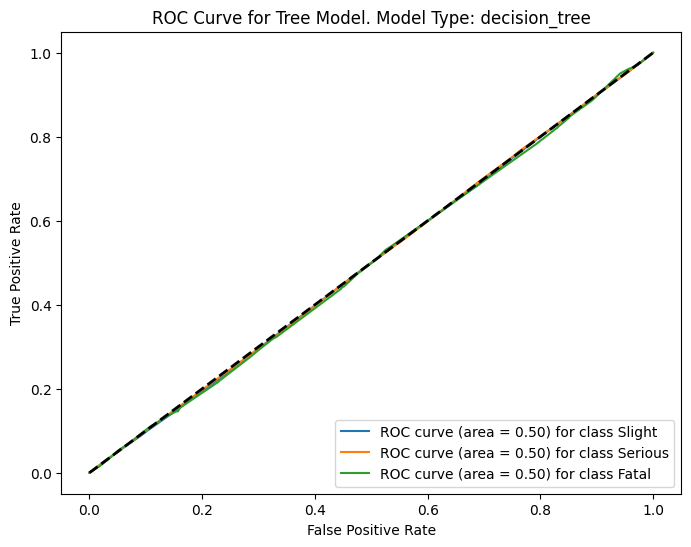

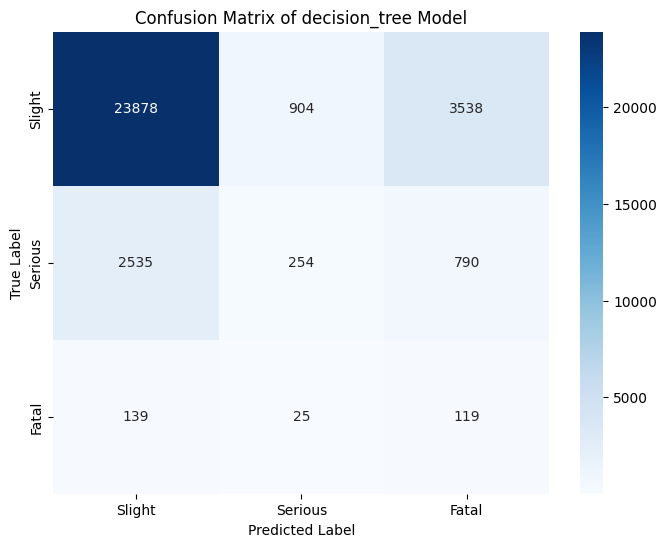

In [ ]:
run_tree(df, model_type = 'decision_tree', max_depth = 7)


Classification Report. Model Type: decision_tree 

              precision    recall  f1-score   support

      Slight       0.89      0.90      0.90    141602
     Serious       0.20      0.17      0.18     17893
       Fatal       0.05      0.12      0.07      1416

    accuracy                           0.81    160911
   macro avg       0.38      0.40      0.39    160911
weighted avg       0.81      0.81      0.81    160911



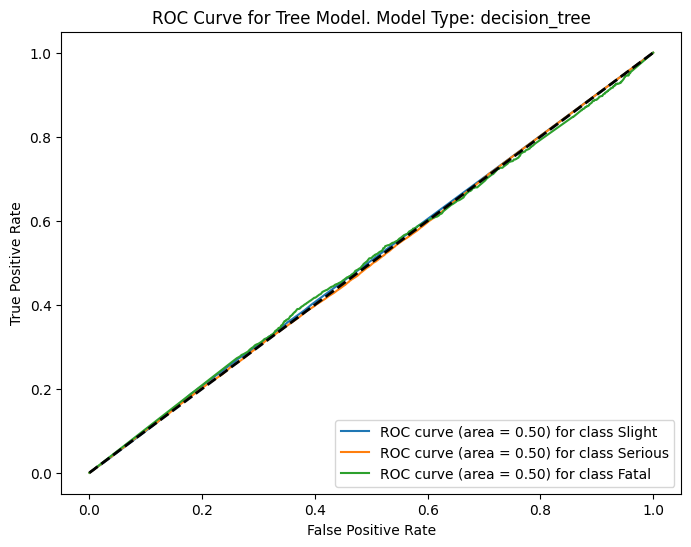

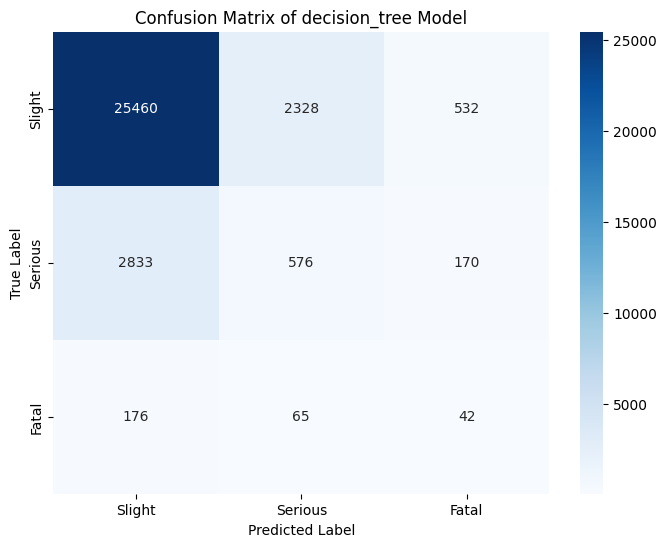

In [ ]:
run_tree(df, model_type = 'decision_tree', max_depth = 20)

#### XG Booster


Classification Report. Model Type: xgb 

              precision    recall  f1-score   support

      Slight       0.89      0.99      0.94    141602
     Serious       0.41      0.06      0.10     17893
       Fatal       0.25      0.02      0.04      1416

    accuracy                           0.88    160911
   macro avg       0.51      0.36      0.36    160911
weighted avg       0.83      0.88      0.83    160911



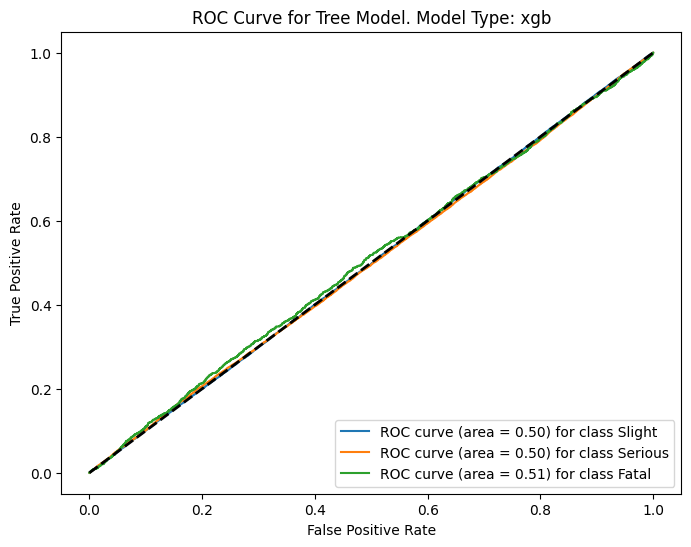

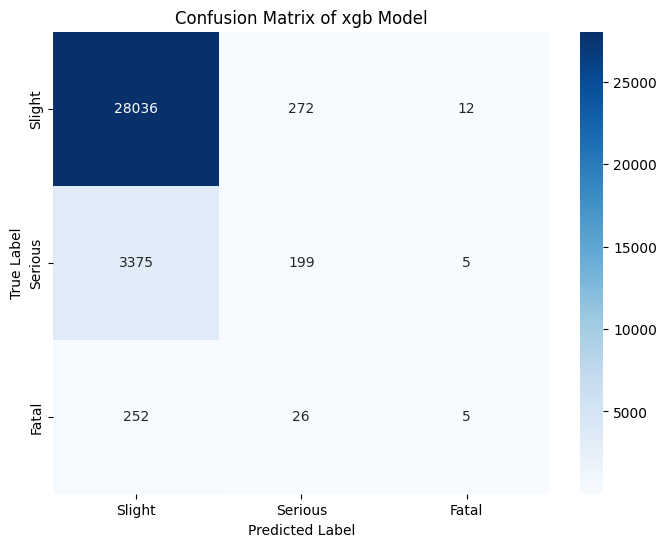

In [ ]:
run_tree(df, model_type='xgb', max_depth = 10)

#### Random Forest


Classification Report. Model Type: rf 

              precision    recall  f1-score   support

      Slight       0.90      0.88      0.89    141602
     Serious       0.22      0.18      0.20     17893
       Fatal       0.05      0.28      0.09      1416

    accuracy                           0.80    160911
   macro avg       0.39      0.45      0.39    160911
weighted avg       0.82      0.80      0.81    160911



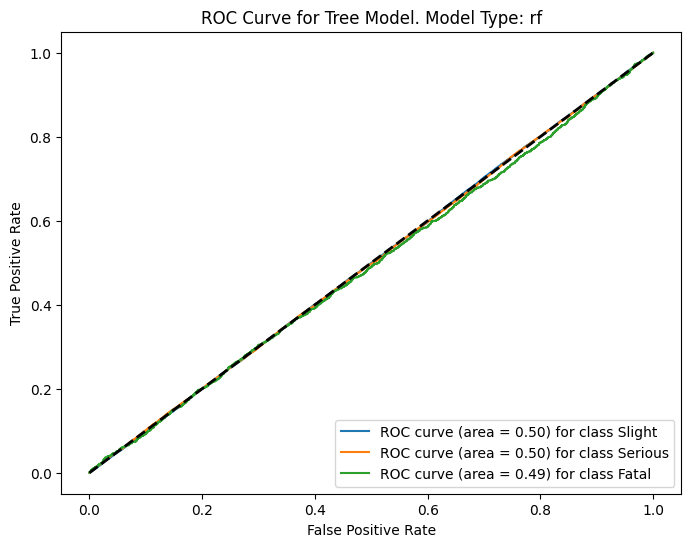

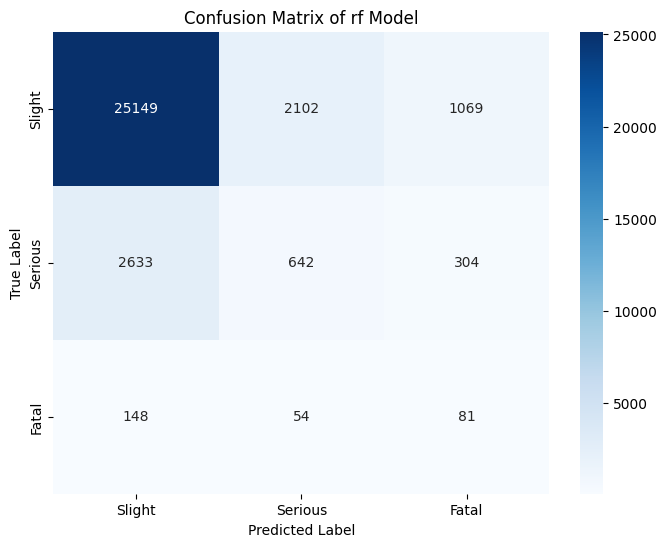

In [ ]:
run_tree(df, model_type = 'rf', max_depth = 10)

* Now the model prefers "Slight" -- "Serious" and "Fatal" are more likely to be predicted as "Slight" compare to random undersampler.
* Random Forest and XGB are hard to interpret. They are more accurate than decision trees if they have the same max depths.
* They seems more accurate than logistic regression model, but since we use a different resampling method for logistic regression, we are not sure if logistic regression model will be more accurate.
* Both their ROC curve performs poorly. The models should be developed more.

***
## Conclusions
* Random Forest & XGB seems perform bettern than logistic regression (including full model and regularization), but they are harder to interpret. Also, since they use different resampling method in this research, further comparison should be applied.
* SMOTE makes the prediction favors "Slight", the majority group, while random undersampling favors "Serious" (neither favors majority group, nor favors the smallest minority group).
* This research does not focus on specific districts. For further research, since each road has a similar distance, divide longitude / latitude by a certain distance and get a mod may be a more efficient method.
* The RUC curve does not perform well in this research.
* One possible reason for models not performing well is there are too many dummy coding variables. Further feature engineering is needed.


---
---